In [219]:
import os

import numpy as np
import pandas as pd

import cv2
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

In [220]:
img_dir = "../../DIP3E_Original_Images_CH03"
img = Image.open(f"{img_dir}/Fig0326(a)(embedded_square_noisy_512).tif")
img = np.asarray(img)

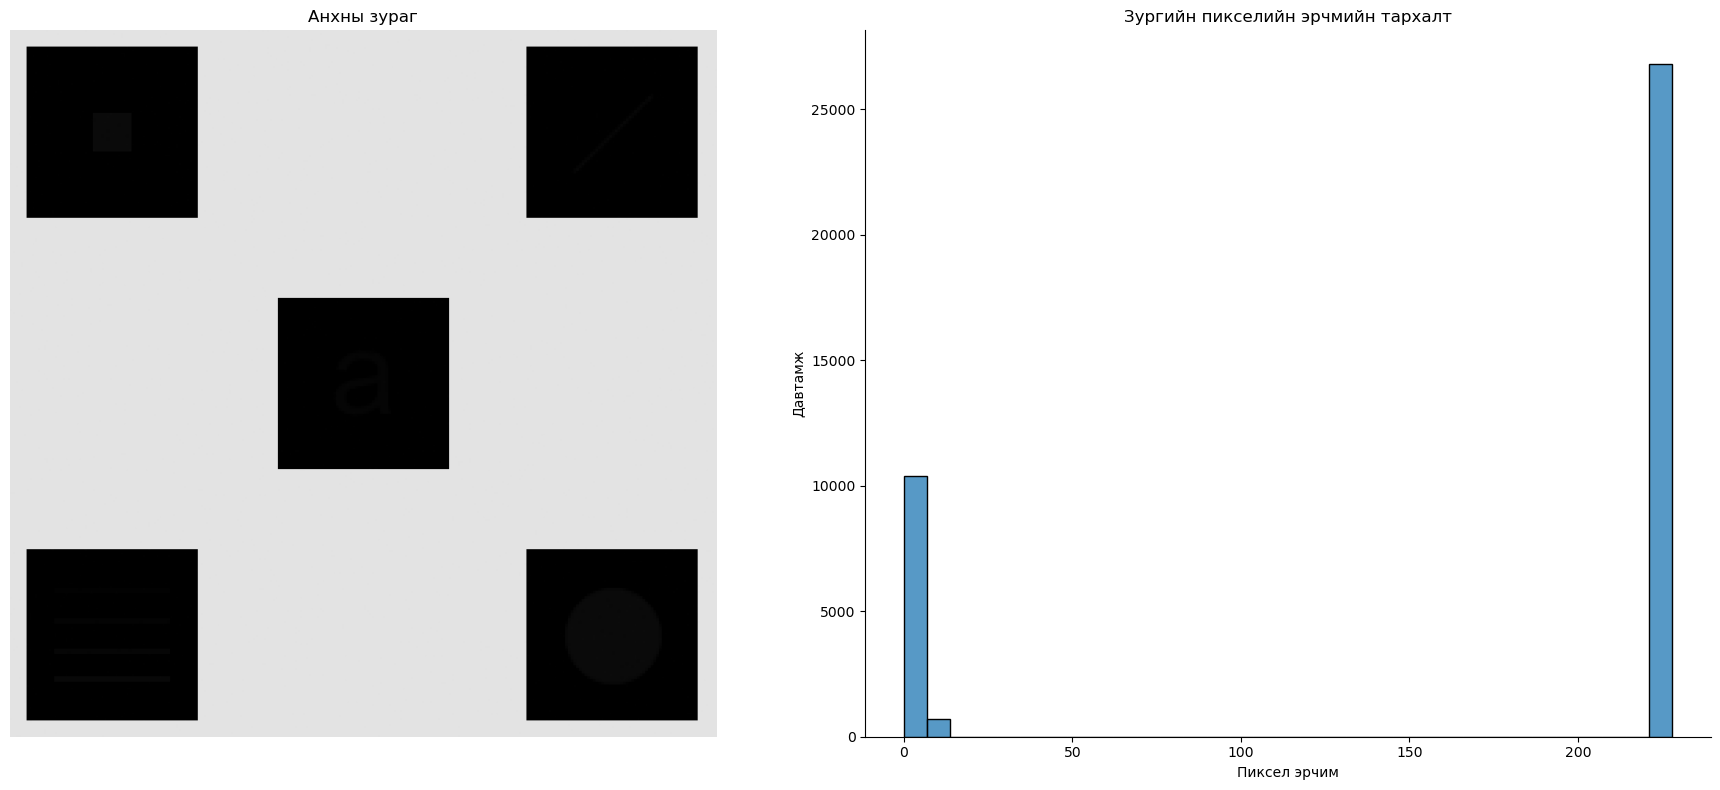

In [221]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 8))
ax1.imshow(img, cmap = 'gray', vmin = 0, vmax = 255)
ax1.set_title("Анхны зураг")
ax1.axis('off')

sns.histplot(img.flatten(), stat = "frequency", ax = ax2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel("Пиксел эрчим");
ax2.set_ylabel("Давтамж")
ax2.set_title("Зургийн пикселийн эрчмийн тархалт")

fig.tight_layout()
fig.savefig("./plots/og_image.png", dpi = 300);

# Global

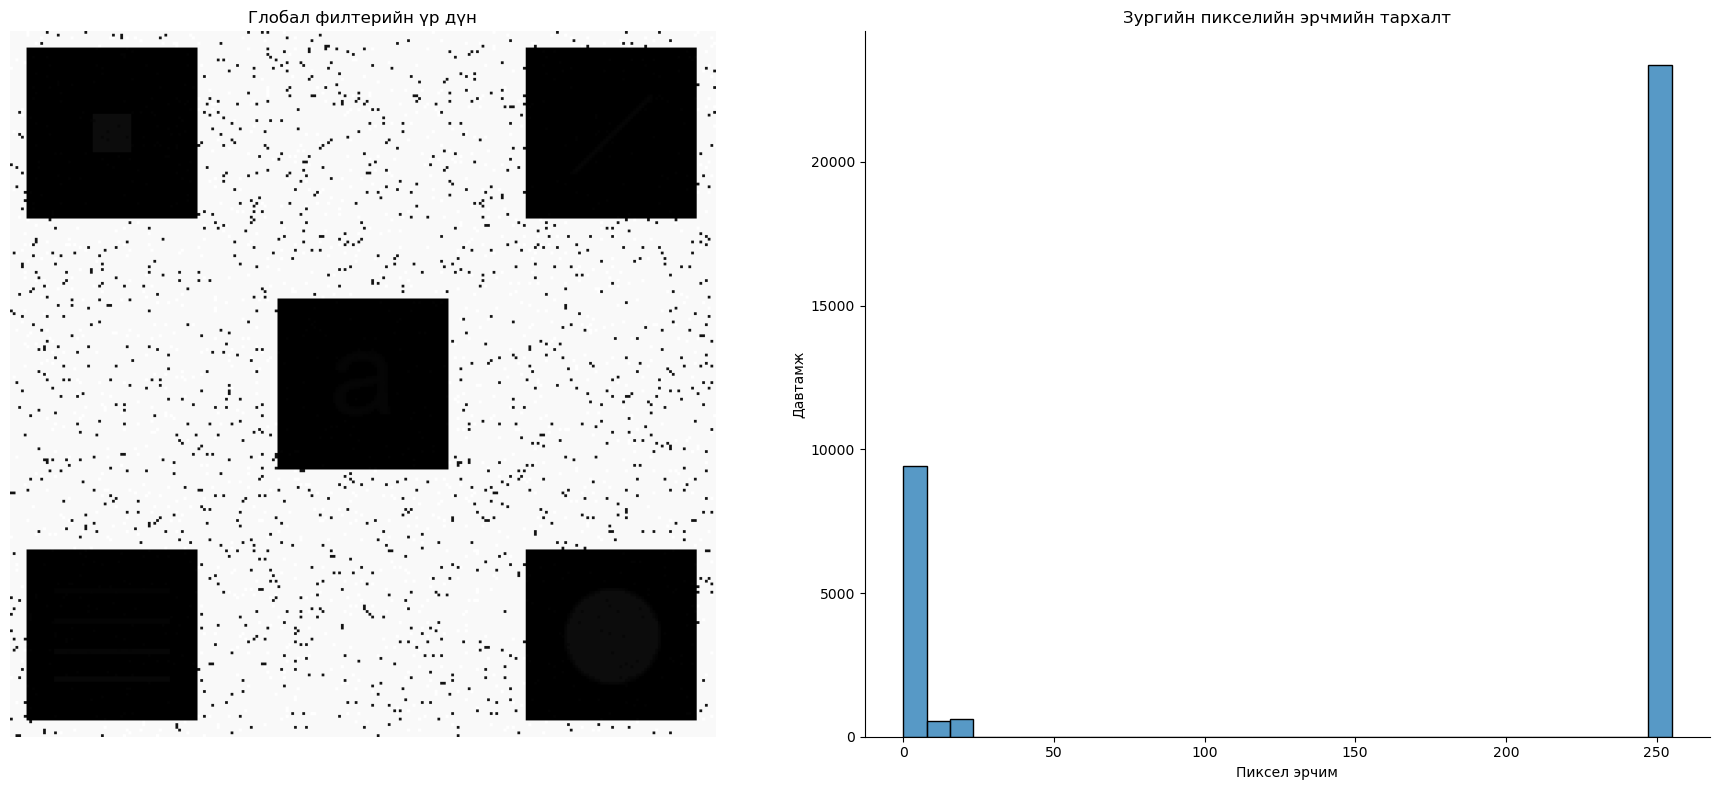

In [222]:
img = Image.open(f"{img_dir}/Fig0326(a)(embedded_square_noisy_512).tif")
img = np.asarray(img)

eq_img = cv2.equalizeHist(img)
#img_hist = cv2.calcHist(eq_img, [0], None, [256], [0, 256])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 8))
ax1.imshow(eq_img, cmap = 'gray', vmin = 0, vmax = 255)
ax1.set_title("Глобал филтерийн үр дүн")
ax1.axis('off')

sns.histplot(eq_img.flatten(), stat = "frequency", ax = ax2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel("Пиксел эрчим");
ax2.set_ylabel("Давтамж")
ax2.set_title("Зургийн пикселийн эрчмийн тархалт")

fig.tight_layout()
fig.savefig("./plots/global_eq.png", dpi = 300);

# Local

In [223]:
def imhist(img):
    row, col = img.shape
    h = [0] * 256

    for i in range(row):
        for j in range(col):
            h[img[i, j]] += 1
    
    return np.array(h)/(row*col)

def cumsum(h):
    return [sum(h[:i+1]) for i in range(len(h))]

def hist_eq(img):
    h = imhist(img)
    cdf = np.array(cumsum(h)) 
    sk = np.uint8(255 * cdf)
    s1, s2 = img.shape
    Y = np.zeros_like(img)
    
    for i in range(s1):
        for j in range(s2):
            Y[i, j] = sk[img[i, j]]
            
    H = imhist(Y)
    return Y, h, H, sk

In [224]:
def local_hist_eq(img, mask_size, stride = 1):
    height, width = img.shape
    mask_iter = mask_size // 2
    enhanced_image = np.zeros((height, width), dtype = np.uint8)

    padding = mask_iter * stride
    padded_img = np.pad(img, pad_width = ((padding, padding), (padding, padding)), 
                        mode = 'constant', constant_values = 0)

    for i in range(mask_iter, height + mask_iter, stride):
        for j in range(mask_iter, width + mask_iter, stride):
            neighborhood = padded_img[i - mask_iter: i + mask_iter + 1, j - mask_iter: j + mask_iter + 1]
            hist = np.histogram(neighborhood, bins = np.arange(256))[0]
            cdf = hist.cumsum()

            if neighborhood.shape[1] <= mask_iter:
                enhanced_pixel = cdf[neighborhood[mask_iter, 0]] * 255 / cdf[-1]
            elif neighborhood.shape[0] <= mask_iter:
                enhanced_pixel = cdf[neighborhood[0, mask_iter]] * 255 / cdf[-1]
            else:
                enhanced_pixel = cdf[neighborhood[mask_iter, mask_iter]] * 255 / cdf[-1]
            enhanced_image[i-mask_iter, j-mask_iter] = enhanced_pixel
            
    return enhanced_image

In [225]:
img = Image.open(f"{img_dir}/Fig0326(a)(embedded_square_noisy_512).tif")
img = np.asarray(img)

enhanced_image = local_hist_eq(img, 3, stride = 1)

In [226]:
df_len = len(img.flatten())
pixel_int_df = pd.DataFrame({'pixel': list(img.flatten()) + list(enhanced_image.flatten()),
                             'type': ['Анхны пиксел эрчим'] * df_len + ['Локал филтер пиксел эрчим'] * df_len})

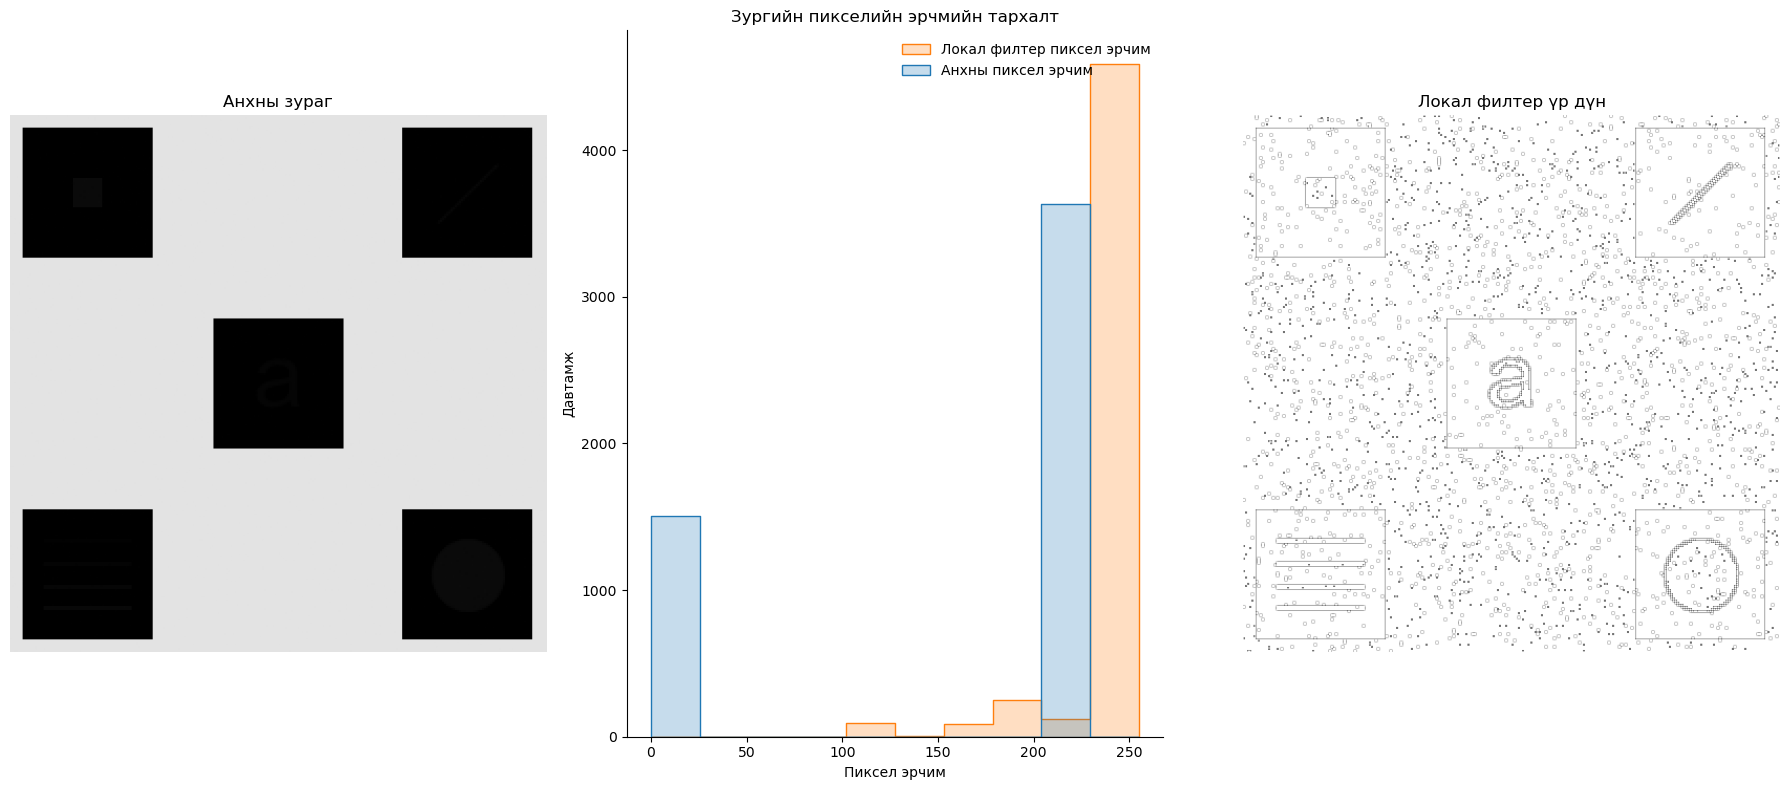

In [227]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18, 8))

ax1.imshow(img, cmap = 'gray', vmin = 0, vmax = 255)
ax1.set_title("Анхны зураг")
ax1.axis('off')

sns.histplot(data = pixel_int_df, x = 'pixel', hue = 'type', stat = "frequency", 
             bins = 10, element = "step", ax = ax2, legend = False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel("Пиксел эрчим");
ax2.set_ylabel("Давтамж")
ax2.set_title("Зургийн пикселийн эрчмийн тархалт")
ax2.legend(['Локал филтер пиксел эрчим', 'Анхны пиксел эрчим'], frameon = False)

ax3.imshow(enhanced_image, cmap = 'gray', vmin = 0, vmax = 255)
ax3.set_title("Локал филтер үр дүн")
ax3.axis('off')

fig.tight_layout()
fig.savefig("./plots/local_eq_1.png", dpi = 300)

In [228]:
def stride_viz(height, width, stride, mask_size):
    iter_cnt = 0
    mask_iter = mask_size // 2
    img = np.zeros((height, width))

    for i in range(mask_iter, height + mask_iter, stride):
        for j in range(mask_iter, width + mask_iter, stride):
            img[i - mask_iter: i + mask_iter + 1, j - mask_iter: j + mask_iter + 1] = 1
            iter_cnt += 1
    
    return img, iter_cnt

height, width = (100, 100)
img_1, iter_cnt_1 = stride_viz(height, width, stride = 1, mask_size = 5)
img_2, iter_cnt_2 = stride_viz(height, width, stride = 3, mask_size = 5)
img_3, iter_cnt_3 = stride_viz(height, width, stride = 5, mask_size = 5)
img_4, iter_cnt_4 = stride_viz(height, width, stride = 7, mask_size = 5)
img_5, iter_cnt_5 = stride_viz(height, width, stride = 8, mask_size = 5)
img_6, iter_cnt_6 = stride_viz(height, width, stride = 11, mask_size = 5)

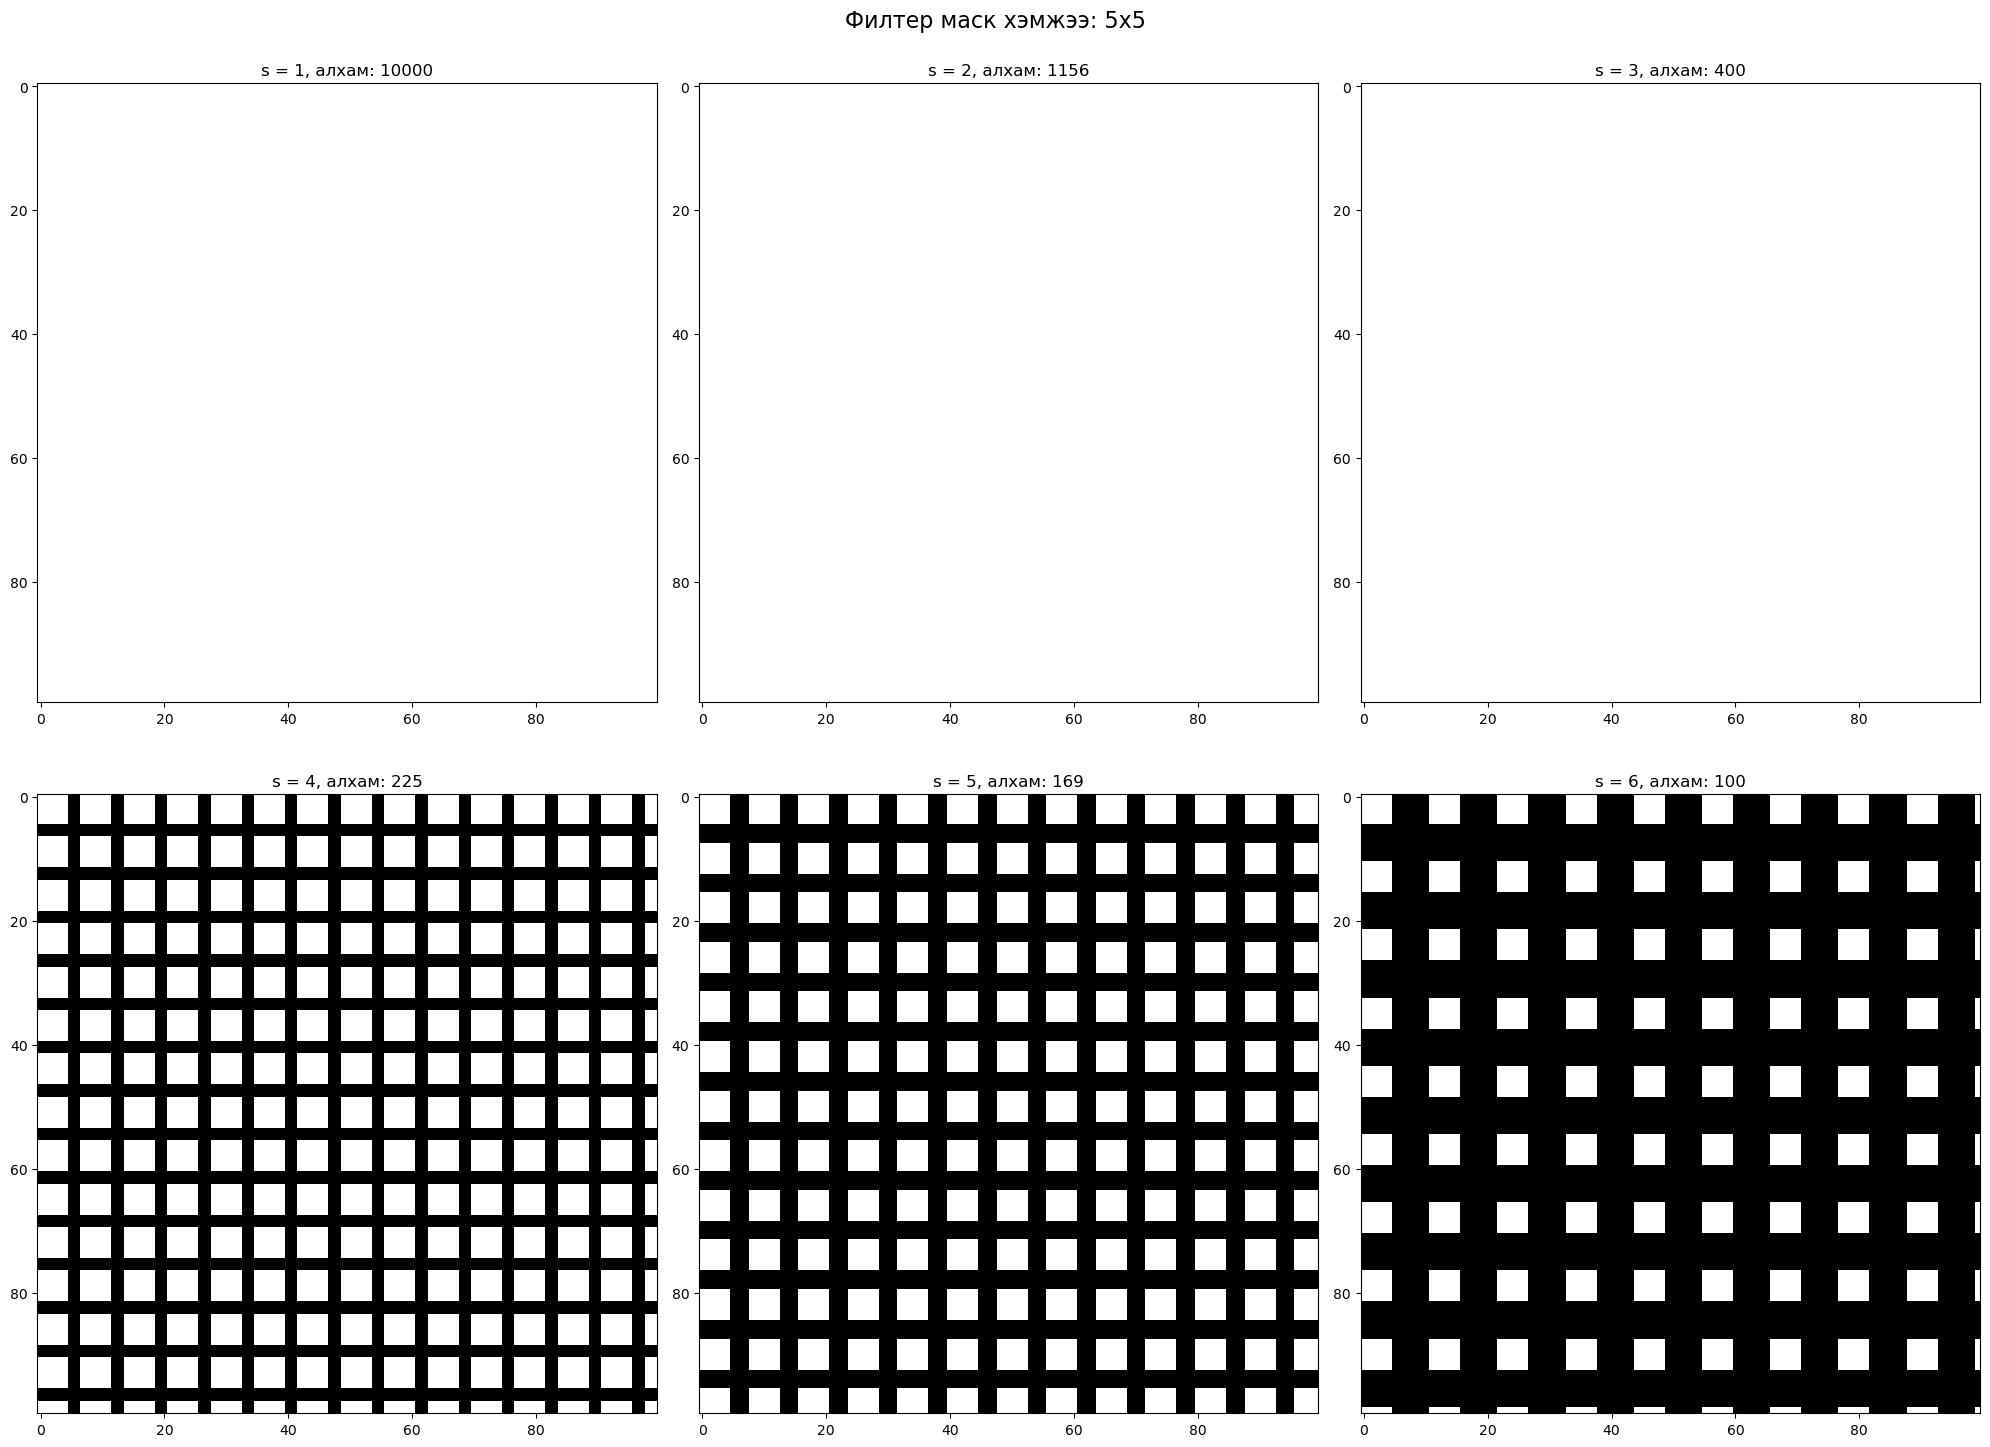

In [229]:
fig, ((ax1, ax2, ax3),
      (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (20, 15))

fig.suptitle("Филтер маск хэмжээ: 5x5", fontsize = 16)

ax1.imshow(img_1, cmap = 'gray', vmin = 0, vmax = 1)
ax1.set_title(f"s = 1, алхам: {iter_cnt_1}")

ax2.imshow(img_2, cmap = 'gray', vmin = 0, vmax = 1)
ax2.set_title(f"s = 2, алхам: {iter_cnt_2}")

ax3.imshow(img_3, cmap = 'gray', vmin = 0, vmax = 1)
ax3.set_title(f"s = 3, алхам: {iter_cnt_3}")

ax4.imshow(img_4, cmap='gray')
ax4.set_title(f"s = 4, алхам: {iter_cnt_4}")

ax5.imshow(img_5, cmap='gray')
ax5.set_title(f"s = 5, алхам: {iter_cnt_5}")

ax6.imshow(img_6, cmap='gray')
ax6.set_title(f"s = 6, алхам: {iter_cnt_6}");

fig.tight_layout()
fig.savefig("./plots/mask_stride_size.png", dpi = 300)

In [230]:
img = Image.open(f"{img_dir}/Fig0326(a)(embedded_square_noisy_512).tif")
img = np.asarray(img)

enhanced_image_1 = local_hist_eq(img, mask_size = 3, stride = 1)
enhanced_image_2 = local_hist_eq(img, mask_size = 3, stride = 2)
enhanced_image_3 = local_hist_eq(img, mask_size = 3, stride = 3)
enhanced_image_4 = local_hist_eq(img, mask_size = 3, stride = 4)
enhanced_image_5 = local_hist_eq(img, mask_size = 3, stride = 5)
enhanced_image_6 = local_hist_eq(img, mask_size = 3, stride = 6)

In [231]:
df_len = len(enhanced_image_1.flatten())
pixel_int_df = pd.DataFrame({'pixel': list(enhanced_image_1.flatten()) + list(enhanced_image_2.flatten()) + list(enhanced_image_3.flatten()),
                             'type': ['S = 1'] * df_len + ['S = 2'] * df_len + ['S = 3'] * df_len})

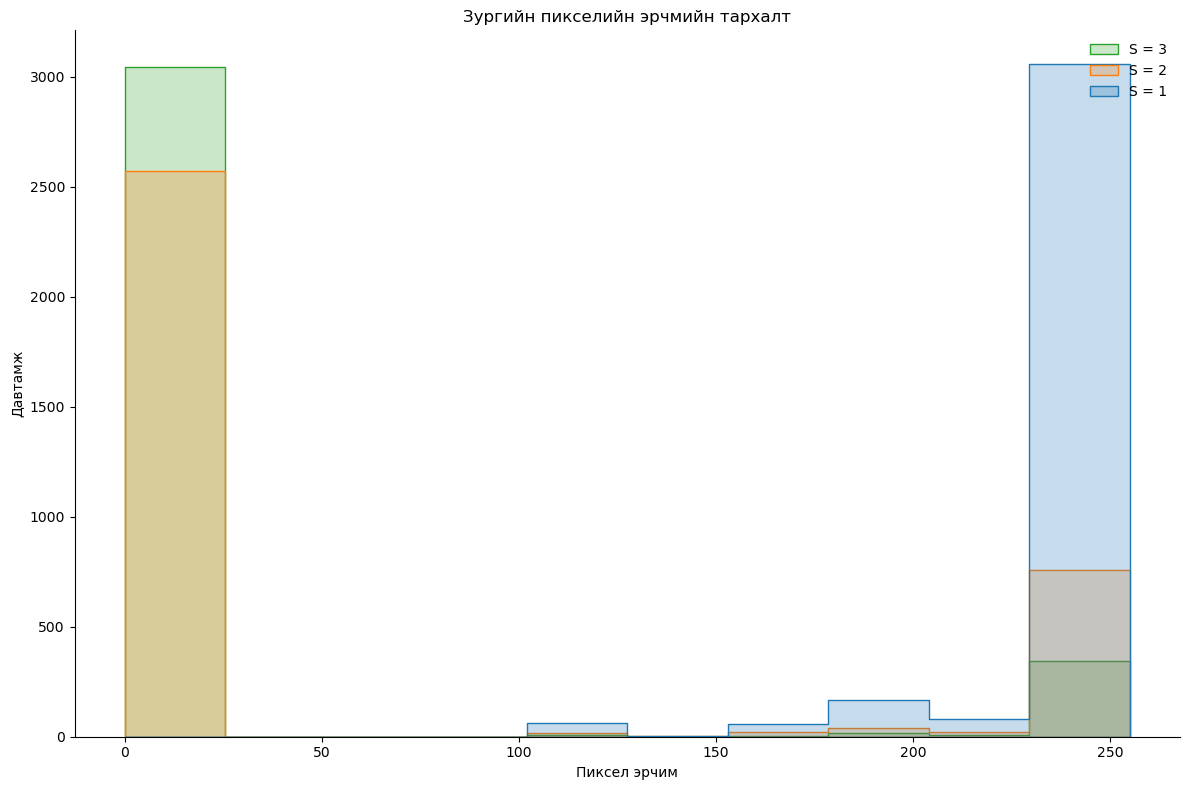

In [232]:
fig, ax = plt.subplots(figsize = (12, 8))

sns.histplot(data = pixel_int_df, x = 'pixel', hue = 'type', stat = "frequency", 
             bins = 10, element = "step", ax = ax, legend = False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Пиксел эрчим");
ax.set_ylabel("Давтамж")
ax.set_title("Зургийн пикселийн эрчмийн тархалт")
legend_labels = ['S = 3', 'S = 2', 'S = 1']
ax.legend(legend_labels, frameon = False, loc = 'upper right')

fig.tight_layout()
fig.savefig("./plots/img_strides_hist.png", dpi = 300)

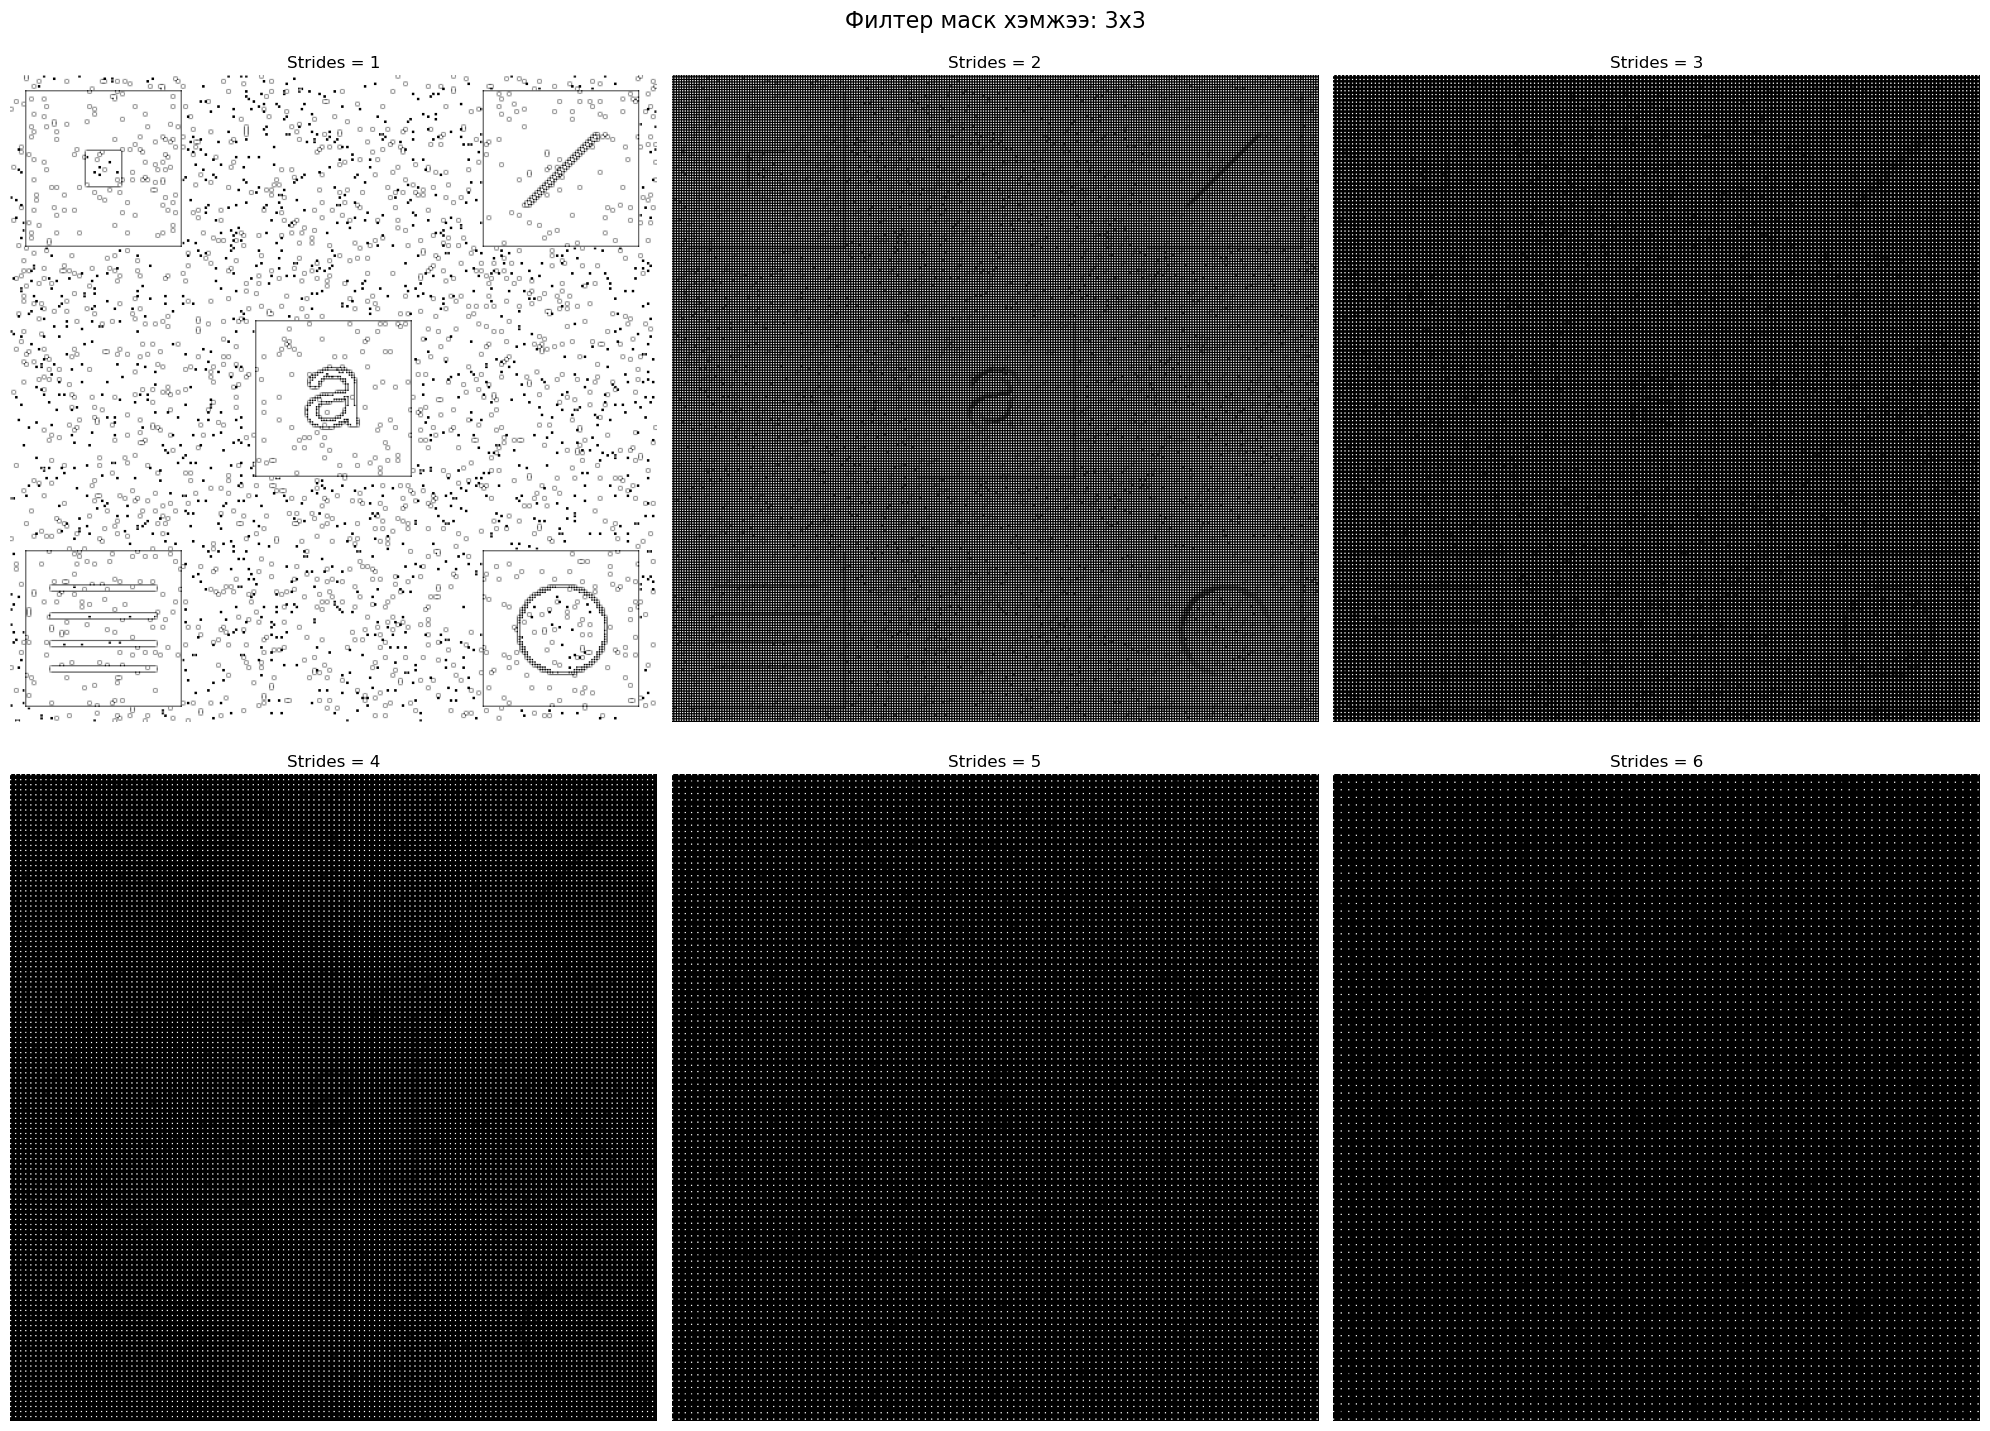

In [233]:
fig, ((ax1, ax2, ax3),
      (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (20, 15))

fig.suptitle(f"Филтер маск хэмжээ: {3}x{3}", fontsize = 16)

ax1.imshow(enhanced_image_1, cmap = 'gray')
ax1.set_title(f"Strides = 1")
ax1.axis('off')

ax2.imshow(enhanced_image_2, cmap = 'gray')
ax2.set_title(f"Strides = 2")
ax2.axis('off')

ax3.imshow(enhanced_image_3, cmap = 'gray')
ax3.set_title(f"Strides = 3")
ax3.axis('off')

ax4.imshow(enhanced_image_4, cmap='gray')
ax4.set_title(f"Strides = 4")
ax4.axis('off')

ax5.imshow(enhanced_image_5, cmap='gray')
ax5.set_title(f"Strides = 5")
ax5.axis('off')

ax6.imshow(enhanced_image_6, cmap='gray')
ax6.set_title(f"Strides = 6");
ax6.axis('off')

fig.tight_layout()
fig.savefig("./plots/mask_3_strides.png", dpi = 300)

In [234]:
img = Image.open(f"{img_dir}/Fig0326(a)(embedded_square_noisy_512).tif")
img = np.asarray(img)

enhanced_image_1 = local_hist_eq(img, mask_size = 3, stride = 1)
enhanced_image_2 = local_hist_eq(img, mask_size = 6, stride = 1)
enhanced_image_3 = local_hist_eq(img, mask_size = 12, stride = 1)
enhanced_image_4 = local_hist_eq(img, mask_size = 24, stride = 1)
enhanced_image_5 = local_hist_eq(img, mask_size = 48, stride = 1)
enhanced_image_6 = local_hist_eq(img, mask_size = 96, stride = 1)

In [235]:
df_len = len(enhanced_image_1.flatten())
pixel_int_df = pd.DataFrame({'pixel': list(enhanced_image_1.flatten()) + list(enhanced_image_4.flatten()) + list(enhanced_image_6.flatten()),
                             'type': ['M = 1'] * df_len + ['M = 24'] * df_len + ['M = 96'] * df_len})

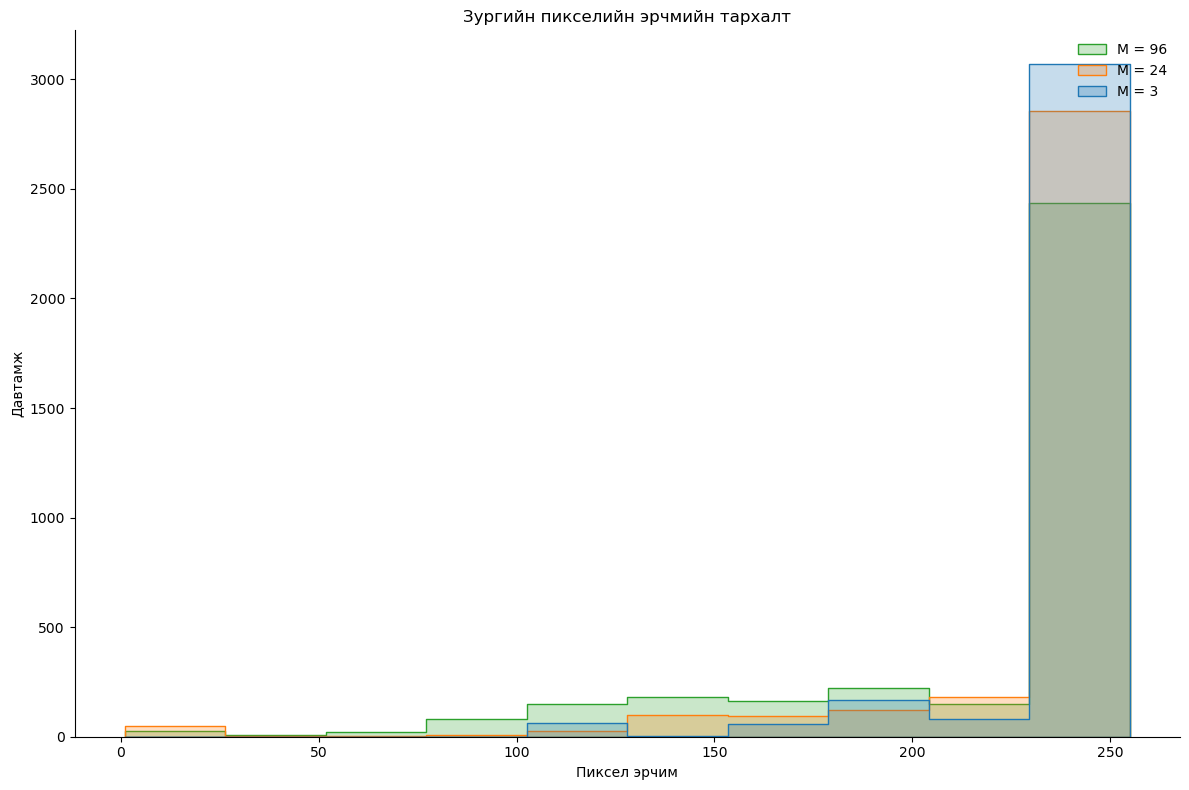

In [236]:
fig, ax = plt.subplots(figsize = (12, 8))

sns.histplot(data = pixel_int_df, x = 'pixel', hue = 'type', stat = "frequency", 
             bins = 10, element = "step", ax = ax, legend = False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Пиксел эрчим");
ax.set_ylabel("Давтамж")
ax.set_title("Зургийн пикселийн эрчмийн тархалт")
legend_labels = ['M = 96', 'M = 24', 'M = 3']
ax.legend(legend_labels, frameon = False, loc = 'upper right')

fig.tight_layout()
fig.savefig("./plots/img_same_strides_diff_mask_hist.png", dpi = 300)

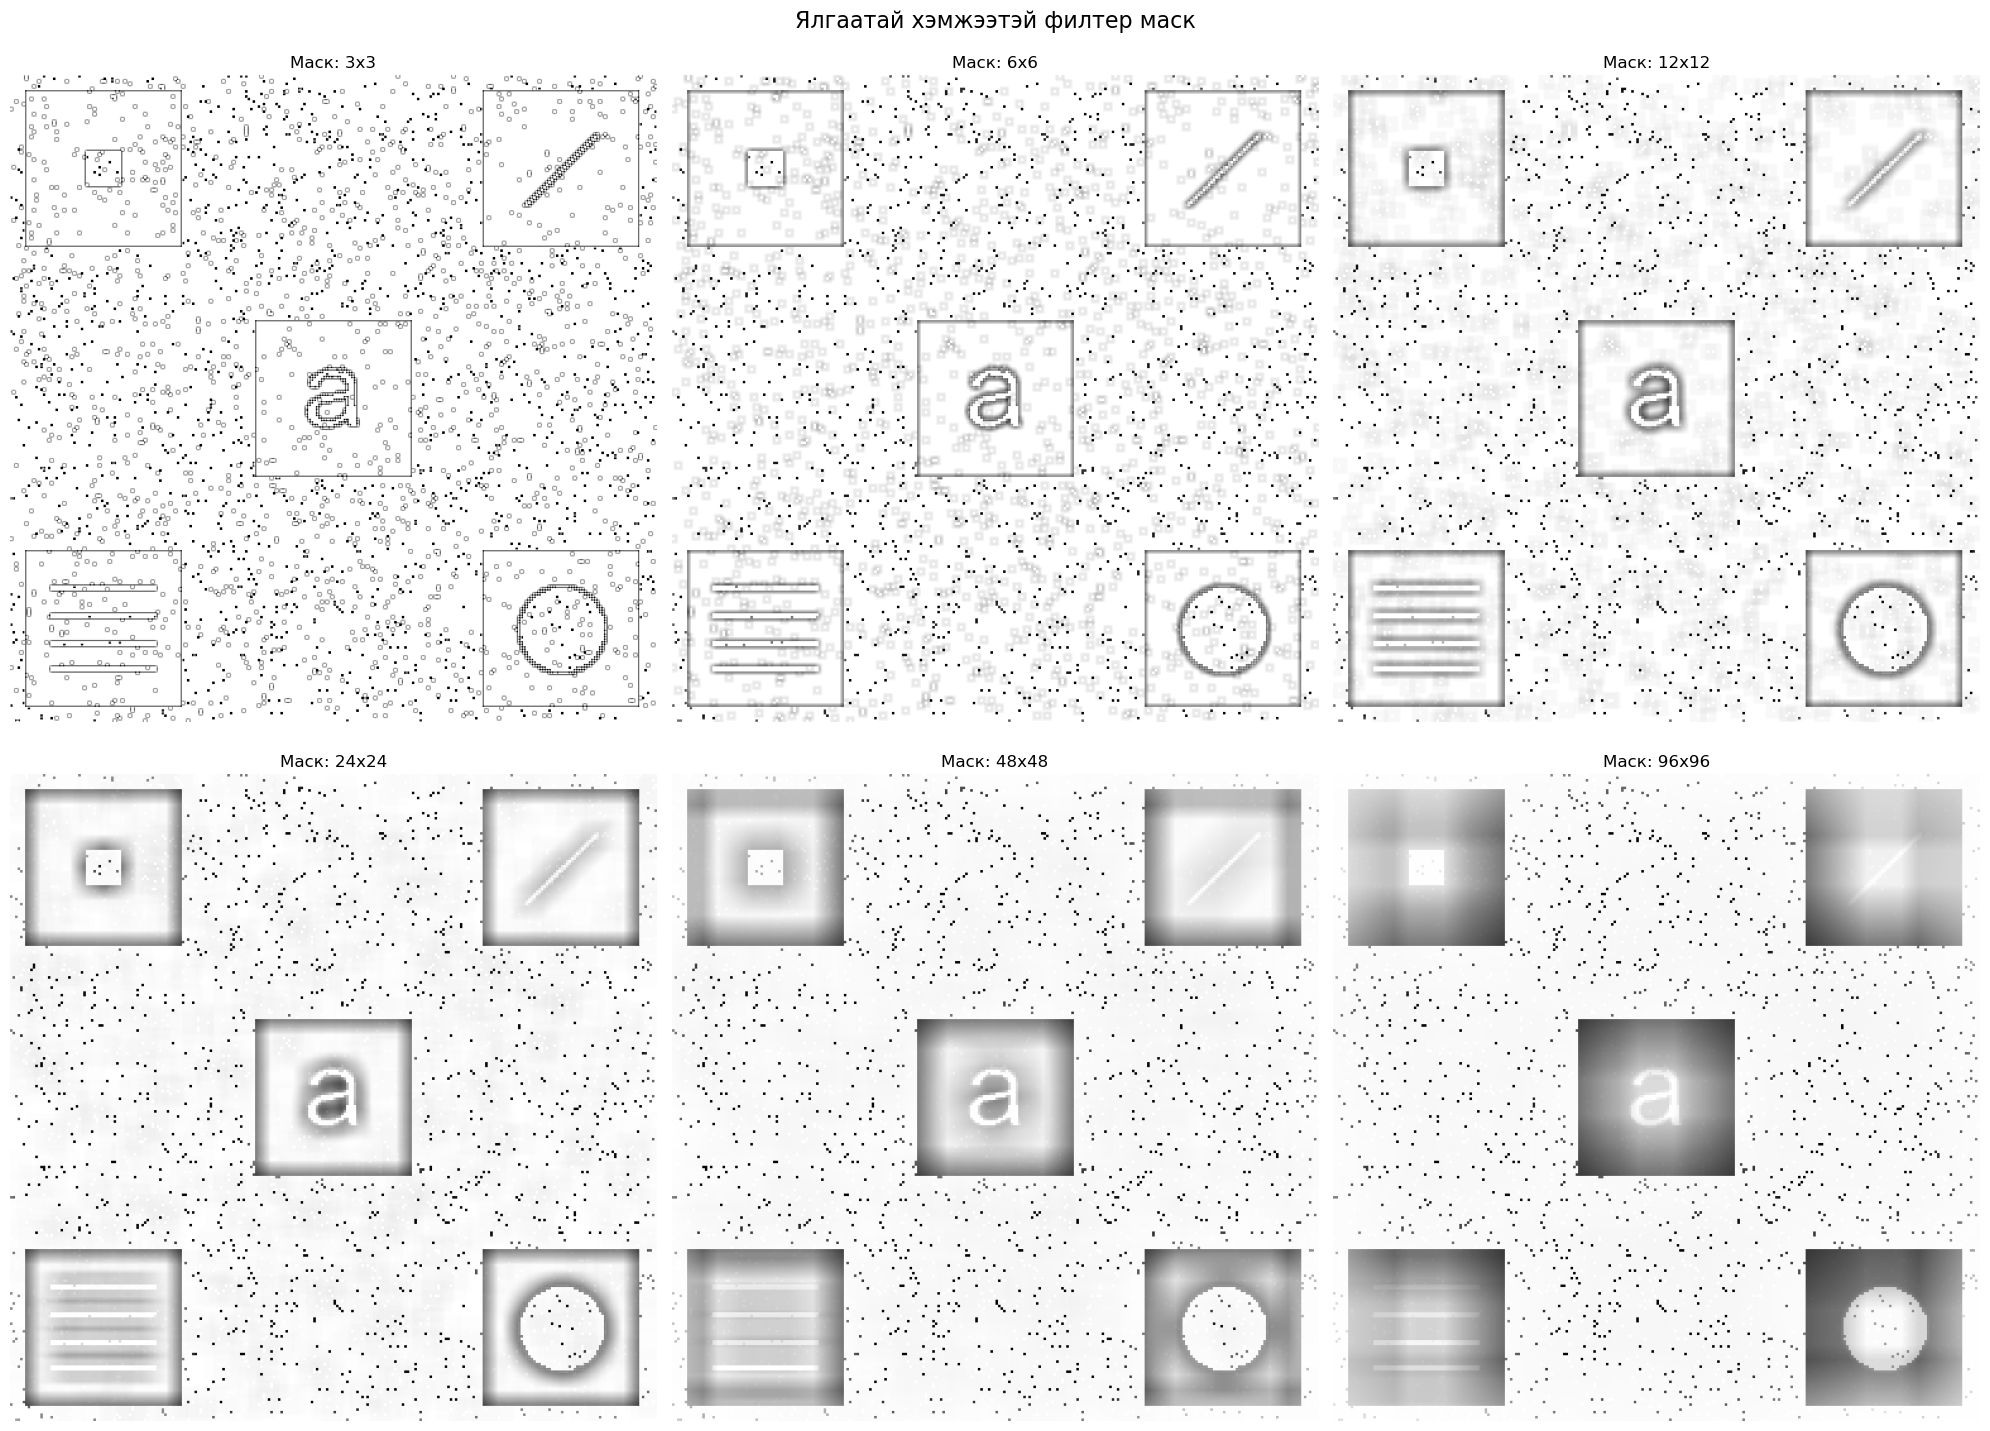

In [237]:
fig, ((ax1, ax2, ax3),
      (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize = (20, 15))

fig.suptitle("Ялгаатай хэмжээтэй филтер маск", fontsize = 16)

ax1.imshow(enhanced_image_1, cmap = 'gray')
ax1.set_title(f"Маск: 3x3")
ax1.axis('off')

ax2.imshow(enhanced_image_2, cmap = 'gray')
ax2.set_title(f"Маск: 6x6")
ax2.axis('off')

ax3.imshow(enhanced_image_3, cmap = 'gray')
ax3.set_title(f"Маск: 12x12")
ax3.axis('off')

ax4.imshow(enhanced_image_4, cmap='gray')
ax4.set_title(f"Маск: 24x24")
ax4.axis('off')

ax5.imshow(enhanced_image_5, cmap='gray')
ax5.set_title(f"Маск: 48x48")
ax5.axis('off')

ax6.imshow(enhanced_image_6, cmap='gray')
ax6.set_title(f"Маск: 96x96");
ax6.axis('off')

fig.tight_layout()
fig.savefig("./plots/mask_different_strides_1.png", dpi = 300)